In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

In [2]:
class BoneType:
    HEAD = "HEAD"
    TORSO = "TORSO"
    LEFT_UP_ARM = "LEFT_UP_ARM"
    LEFT_DOWN_ARM = "LEFT_DOWN_ARM"
    RIGHT_UP_ARM = "RIGHT_UP_ARM"
    RIGHT_DOWN_ARM = "RIGHT_DOWN_ARM"
    LEFT_UP_LEG = "LEFT_UP_LEG"
    LEFT_DOWN_LEG = "LEFT_DOWN_LEG"
    RIGHT_UP_LEG = "RIGHT_UP_LEG"
    RIGHT_DOWN_LEG = "RIGHT_DOWN_LEG"
    
class JointType:
    HEAD = 0
    NECK = 1
    LEFT_SHOULDER = 2
    RIGHT_SHOULDER = 3
    LEFT_ELBOW = 4
    RIGHT_ELBOW = 5
    LEFT_HAND = 6
    RIGHT_HAND = 7
    TORSO = 8
    LEFT_HIP = 9
    RIGHT_HIP = 10
    LEFT_KNEE = 11
    RIGHT_KNEE = 12
    LEFT_FOOT = 13
    RIGHT_FOOT = 14
    
joint_pairs = {}
joint_pairs[BoneType.HEAD] = [
    (JointType.HEAD, JointType.NECK)
]
joint_pairs[BoneType.TORSO] = [
    (JointType.NECK, JointType.LEFT_SHOULDER),
    (JointType.NECK, JointType.RIGHT_SHOULDER),
    (JointType.NECK, JointType.TORSO),
    (JointType.TORSO, JointType.LEFT_SHOULDER),
    (JointType.TORSO, JointType.RIGHT_SHOULDER),
    (JointType.TORSO, JointType.LEFT_HIP),
    (JointType.TORSO, JointType.RIGHT_HIP),
    (JointType.LEFT_HIP, JointType.RIGHT_HIP),
]
joint_pairs[BoneType.LEFT_UP_ARM] = [
    (JointType.LEFT_SHOULDER, JointType.LEFT_ELBOW)
]
joint_pairs[BoneType.LEFT_DOWN_ARM] = [
    (JointType.LEFT_ELBOW, JointType.LEFT_HAND)
]
joint_pairs[BoneType.RIGHT_UP_ARM] = [
    (JointType.RIGHT_SHOULDER, JointType.RIGHT_ELBOW)
]
joint_pairs[BoneType.RIGHT_DOWN_ARM] = [
    (JointType.RIGHT_ELBOW, JointType.RIGHT_HAND)
]
joint_pairs[BoneType.LEFT_UP_LEG] = [
    (JointType.LEFT_HIP, JointType.LEFT_KNEE)
]
joint_pairs[BoneType.LEFT_DOWN_LEG] = [
    (JointType.LEFT_KNEE, JointType.LEFT_FOOT)
]
joint_pairs[BoneType.RIGHT_UP_LEG] = [
    (JointType.RIGHT_HIP, JointType.RIGHT_KNEE)
]
joint_pairs[BoneType.RIGHT_DOWN_LEG] = [
    (JointType.RIGHT_KNEE, JointType.RIGHT_FOOT)
]

In [3]:
dir = "./images/bodyparts/"
stamp = 1478268857926037
img_file = dir + str(stamp) + ".png"
json_file = dir + str(stamp) + ".json"

In [4]:
img = cv2.imread(img_file)

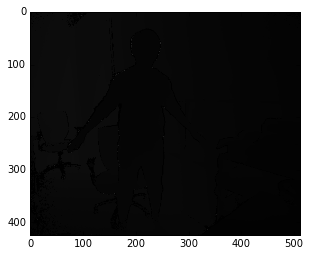

In [5]:
plt.imshow(img)

In [6]:
skeletons = pd.read_json(json_file)
skeleton = skeletons["skeletons"][0]
joints = skeleton["joints"]
pixels = skeleton["pixels"]

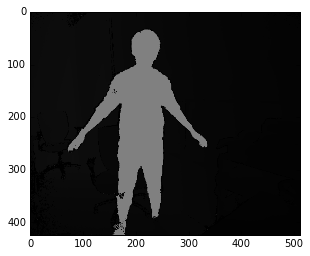

In [7]:
for px in pixels:
    img[px[1], px[0]] = [128, 128, 128]
plt.imshow(img)

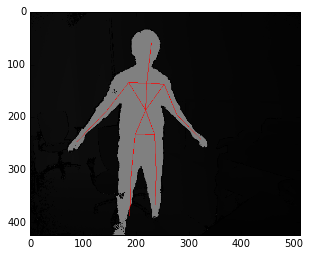

In [8]:
img_skeleton = img.copy()

for bone_type, pairs in joint_pairs.iteritems():
    for pair in pairs:
        j0 = [int(i) for i in [j for j in joints if j["key"] == pair[0]][0]["value"]]
        j1 = [int(i) for i in [j for j in joints if j["key"] == pair[1]][0]["value"]]
        cv2.line(img_skeleton, tuple(j0), tuple(j1), (255, 0, 0))
        
plt.imshow(img_skeleton)

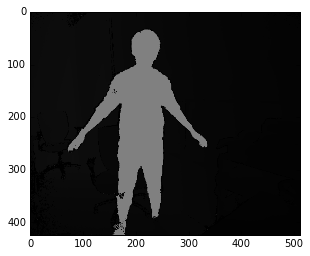

In [9]:
plt.imshow(img)